In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil


In [2]:
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

In [3]:
# выбрали  уровень доверия 95% (альфа 0,05), мощность теста - 0,8 проводим Анализ Мощности Выборки
# целевая переменная - уровень конверсии (аналогично примеру), Размах Эффекта - 2%
effect_size = sms.proportion_effectsize(0.13, 0.15)
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)
required_n = ceil(required_n)
print("Для каждой группы нам необходимо не меньше ",required_n, " наблюдений")

Для каждой группы нам необходимо не меньше  4720  наблюдений


In [4]:
df = pd.read_csv('ab_test_ensembles.csv')
df.head(4)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [6]:
# в обеих группах - два варианта работы сервиса - standard и svm_ensemble_v_1_22
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [7]:
# убедились, что пользователи 'уникальны'
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [8]:
# случайным образом достали по 4720 пользователей для каждой группы 
control_sample = df[df['group'] == 'control'].sample(n = required_n, random_state=20)
treatment_sample = df[df['group'] == 'treatment'].sample(n = required_n, random_state=20)

# общая случайная выборка
ab_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_df.reset_index(drop=True, inplace=True)

In [9]:
ab_df.group.value_counts()

group
control      4720
treatment    4720
Name: count, dtype: int64

In [10]:
# рассчитываем выборочные статистики
conversion_rates = ab_df.groupby('group')['converted']
std_proportion = lambda x: np.std(x, ddof=0)
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg(['mean', std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates
#два эксперимента по выборочным статистикам показывают близкие друг к другу значения

,CR mean,CR std,CR se
group,,,
control,0.127331,0.333343,0.004852
treatment,0.126907,0.332869,0.004845


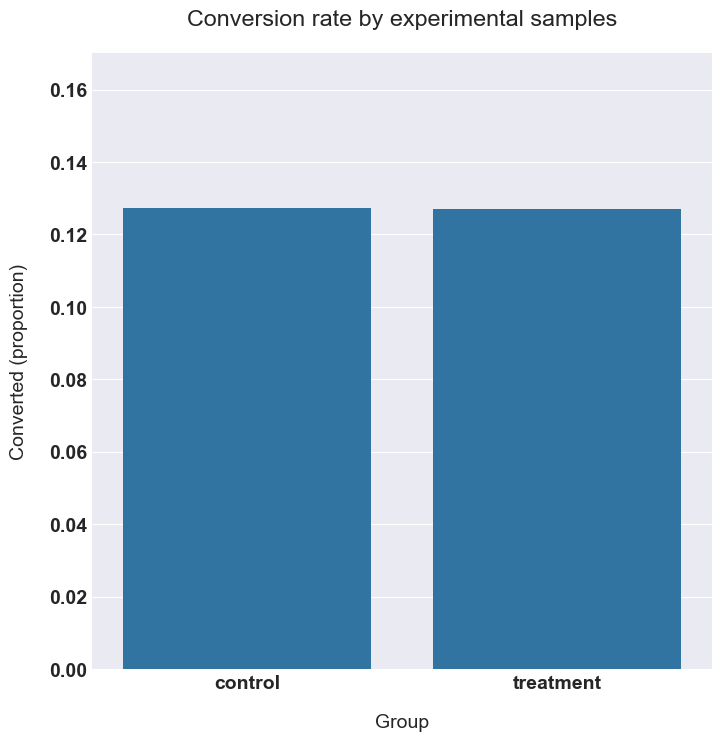

In [11]:
plt.figure(figsize=(8,8));
sns.barplot(x=ab_df['group'], y=ab_df['converted'], errorbar=('ci', False));
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [12]:
# расчитываем p-статистику 
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_df[ab_df['group'] == 'control']['converted']
treatment_results = ab_df[ab_df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 0.06
p-value: 0.951
CI 95% for control group: [0.118, 0.137]
CI 95% for treatment group: [0.117, 0.136]


In [13]:
# p-значение = 0.951  не позводяет отклонить нулевую гипотезу
# более того, уровень конверсии в группе treatment даже ниже, чем в контрольной (график)
# таким образом, стоит оставить старый вариант работы